In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [5]:
#Read csv
file_path = 'Cleaned_data_with_population.csv'

df = pd.read_csv(file_path)

# Sort by LOCATION and TIME for correct growth calculation
df.sort_values(['LOCATION', 'TIME'], inplace=True)
# Calculate growth rates for selected columns
growth_columns = ['PC_HEALTHXP', 'PC_GDP', 'USD_CAP','TOTAL_SPEND','POPULATION']
for col in growth_columns:
    df[f'{col}_GROWTH'] = df.groupby('LOCATION')[col].pct_change()

# Identify the column with the highest growth each year for each location
df['HIGHEST_GROWTH_METRIC'] = df[[f'{col}_GROWTH' for col in growth_columns]].idxmax(axis=1)
df['HIGHEST_GROWTH_VALUE'] = df[[f'{col}_GROWTH' for col in growth_columns]].max(axis=1)

# Optional: clean the metric name (remove "_GROWTH" suffix)
df['HIGHEST_GROWTH_METRIC'] = df['HIGHEST_GROWTH_METRIC'].str.replace('_GROWTH', '')

# Save the result to csv
df.to_csv('Cleaned_data_with_population_growth.csv', index=False)




C:\Users\bmanna\AppData\Local\Temp\ipykernel_22244\2481617357.py:14: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df['HIGHEST_GROWTH_METRIC'] = df[[f'{col}_GROWTH' for col in growth_columns]].idxmax(axis=1)


In [6]:
# Calculate average growth and total spend per location
summary = df.groupby('LOCATION').agg({
    'USD_CAP_GROWTH': 'mean',
    'TOTAL_SPEND': 'mean'
}).reset_index()

# Rename for clarity
summary.rename(columns={
    'USD_CAP_GROWTH': 'AVG_USD_CAP_GROWTH',
    'TOTAL_SPEND': 'AVG_TOTAL_SPEND'
}, inplace=True)

# Determine thresholds (top 25% for growth, bottom 25% for spend)
growth_threshold = summary['AVG_USD_CAP_GROWTH'].quantile(0.75)
spend_threshold = summary['AVG_TOTAL_SPEND'].quantile(0.25)

# Identify countries of interest
summary["TARGET"] = summary.apply(
    lambda row: "Potential" if (row["AVG_USD_CAP_GROWTH"] >= growth_threshold and row["AVG_TOTAL_SPEND"] <= spend_threshold)
    else "Other",
    axis=1
)

# Interactive Plotly scatter plot
fig = px.scatter(
    summary,
    x="AVG_TOTAL_SPEND",
    y="AVG_USD_CAP_GROWTH",
    color="TARGET",
    text="LOCATION",
    hover_data=["LOCATION", "AVG_USD_CAP_GROWTH", "AVG_TOTAL_SPEND"],
    color_discrete_map={"Potential": "red", "Other": "#20557b"},
    labels={
        "AVG_TOTAL_SPEND": "Avg Total Spend",
        "AVG_USD_CAP_GROWTH": "Avg USD_CAP Growth Rate",
        "TARGET": "Country Type"
    },
    title="Countries with High USD_CAP Growth and Low Total Spend"
)

# Improve layout
fig.update_traces(textposition='top center')
fig.update_layout(legend=dict(title="Target Country"))
fig.show()

# Create interactive Choropleth map
fig = px.choropleth(
    summary,
    locations="LOCATION",
    color="TARGET",
    locationmode="ISO-3",
    hover_name="LOCATION",
    hover_data={"AVG_USD_CAP_GROWTH": True, "AVG_TOTAL_SPEND": True},
    color_discrete_map={"Potential": "green", "Other": "#ef98da"},
    title="Countries with High USD_CAP Growth and Low Total Spend"
)

fig.update_layout(geo=dict(showframe=False, showcoastlines=True))
fig.show()



In [7]:
# Calculate average growth and total spend per location
summary = df.groupby('LOCATION').agg({
    'USD_CAP_GROWTH': 'mean',
    'TOTAL_SPEND': 'mean'
}).reset_index()

# Rename for clarity
summary.rename(columns={
    'USD_CAP_GROWTH': 'AVG_USD_CAP_GROWTH',
    'TOTAL_SPEND': 'AVG_TOTAL_SPEND'
}, inplace=True)

# Create 3 quantile bins (33.3%, 66.7%, 100%)
summary["USD_CAP_GROWTH_QUANTILE"] = pd.qcut(
    summary["AVG_USD_CAP_GROWTH"],
    q=3,
    labels=["Low", "Medium", "High"]
)

summary["AVG_TOTAL_SPEND_QUANTILE"] = pd.qcut(
    summary["AVG_TOTAL_SPEND"],
    q=3,
    labels=["Low", "Medium", "High"]
)

# Determine thresholds (top 25% for growth, bottom 25% for spend)

# Identify countries of interest
summary["TARGET"] = summary.apply(
    lambda row: "High Potential" if (row["USD_CAP_GROWTH_QUANTILE"] == 'High' and row["AVG_TOTAL_SPEND_QUANTILE"] == 'Low')
    else "Medium Potential" if (
        (row["USD_CAP_GROWTH_QUANTILE"] == 'High' and row["AVG_TOTAL_SPEND_QUANTILE"] == 'Medium') or
        (row["USD_CAP_GROWTH_QUANTILE"] == 'Medium' and row["AVG_TOTAL_SPEND_QUANTILE"] == 'Low')
    )
    else "Low Potential",
    axis=1
)


# Create interactive Choropleth map
fig = px.choropleth(
    summary,
    locations="LOCATION",
    color="TARGET",
    locationmode="ISO-3",
    hover_name="LOCATION",
    hover_data={"AVG_USD_CAP_GROWTH": True, "AVG_TOTAL_SPEND": True},
    color_discrete_map={"High Potential": "green", "Low Potential": "#ef98da", "Medium Potential" : "#efe298"},
    title="Countries with High USD_CAP Growth and Low Total Spend"
)

fig.update_layout(geo=dict(showframe=False, showcoastlines=True))
fig.show()


c:\Users\bmanna\AppData\Local\miniconda3\envs\dsi_teilnehmer\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



[0.60840322 0.23609551]
      PC_HEALTHXP_GROWTH  PC_GDP_GROWTH  USD_CAP_GROWTH  TOTAL_SPEND_GROWTH  \
PCA1            0.432216       0.516651        0.479262            0.534832   
PCA2            0.329313       0.020187       -0.467277           -0.131387   

      POPULATION_GROWTH  
PCA1           0.174711  
PCA2           0.809651  


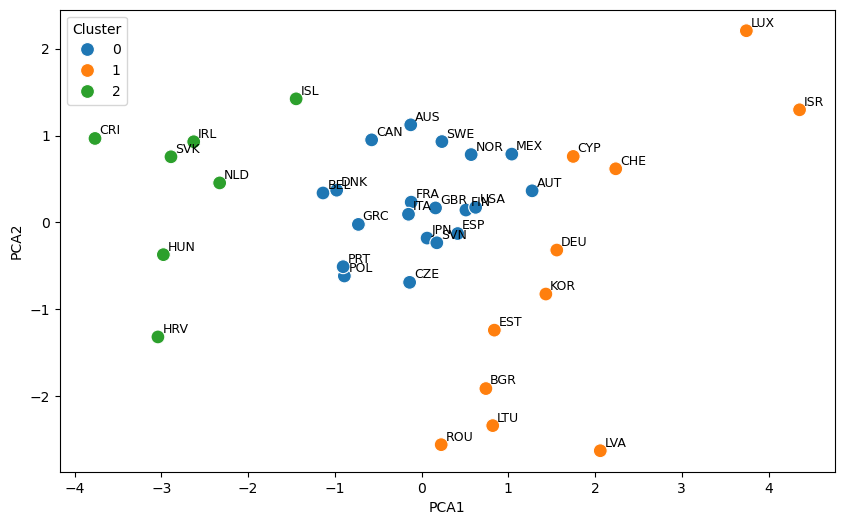

In [12]:
# Step 2: Check for nulls and drop rows with missing growth values
growth_columns = [
    'PC_HEALTHXP_GROWTH',
    'PC_GDP_GROWTH',
    'USD_CAP_GROWTH',
    'TOTAL_SPEND_GROWTH',
    'POPULATION_GROWTH'
]

df_clean = df.dropna(subset=growth_columns)

# Step 3: Aggregate by country — average growth per metric
country_growth = df_clean.groupby('LOCATION')[growth_columns].mean()

# Step 4: Scale the data (important for K-Means)
scaler = StandardScaler()
scaled_growth = scaler.fit_transform(country_growth)

# Step 5: Apply K-Means
k = 3  # You can change this or determine it using the Elbow Method
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(scaled_growth)

# Step 6: Add cluster labels
country_growth['Cluster'] = clusters

# Step 7: Visualize the clusters using PCA for 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_growth)
country_growth['PCA1'] = pca_result[:, 0]
country_growth['PCA2'] = pca_result[:, 1]
print(pca.explained_variance_ratio_)
# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=country_growth, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)

#country_growth
# Show PCA loadings
loadings = pd.DataFrame(
    pca.components_,
    columns=growth_columns,
    index=['PCA1', 'PCA2']
)

print(loadings)

for i in country_growth.index:
    plt.text(x=country_growth.loc[i, 'PCA1'] + 0.05,
             y=country_growth.loc[i, 'PCA2'] + 0.05,
             s=i, fontsize=9)

#plt.title('Country Clusters Based on Growth Behavior (K-Means)')
#plt.xlabel('PCA Component 1')
#plt.ylabel('PCA Component 2')
#plt.grid(True)
#plt.show()

# Optional: Print cluster assignments
#print(country_growth[['Cluster']])




In [17]:
# Step 2: Drop rows with missing values in growth columns
growth_columns = [
    'PC_HEALTHXP_GROWTH',
    'PC_GDP_GROWTH',
    'USD_CAP_GROWTH',
    'TOTAL_SPEND_GROWTH',
    'POPULATION_GROWTH'
]

df_clean = df.dropna(subset=growth_columns)

# Step 3: Aggregate by country
country_growth = df_clean.groupby('LOCATION')[growth_columns].mean()

# Step 4: Scale the data
scaler = StandardScaler()
scaled_growth = scaler.fit_transform(country_growth)

# Step 5: Apply K-Means clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(scaled_growth)
country_growth['Cluster'] = clusters

# Step 6: PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_growth)
country_growth['PCA1'] = pca_result[:, 0]
country_growth['PCA2'] = pca_result[:, 1]

# Step 7: Interactive scatter plot with Plotly
fig = px.scatter(
    country_growth.reset_index(),
    x='PCA1',
    y='PCA2',
    color='Cluster',
    hover_name='LOCATION',
    title='Country Clusters Based on Growth Indicators (PCA View)',
    labels={'PCA1': 'Principal Component 1', 'PCA2': 'Principal Component 2'},
    width=900,
    height=600
)

fig.update_traces(marker=dict(size=12, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(legend_title_text='Cluster')

fig.show()

# Reset index to bring 'LOCATION' (country names or ISO codes) as a column
choropleth_df = country_growth.reset_index()

# Make sure your 'LOCATION' column contains recognized country names or ISO Alpha-3 codes (like 'USA', 'FRA', 'IND')
# If they are country names, set `locations=choropleth_df['LOCATION']` and use `locationmode='country names'`

fig = px.choropleth(
    choropleth_df,
    locations='LOCATION',                 # Country codes or names
    locationmode='ISO-3',         # Use 'ISO-3' if using ISO codes
    color='Cluster',                      # Cluster number to color by
    hover_name='LOCATION',                # Show country name on hover
    #hover_data={"AVG_USD_CAP_GROWTH": True, "AVG_TOTAL_SPEND": True},
    color_continuous_scale='Viridis',     # Or try 'Plasma', 'Cividis', etc.
    title='Country Clusters Based on Growth Metrics'
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()








c:\Users\bmanna\AppData\Local\miniconda3\envs\dsi_teilnehmer\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

